In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

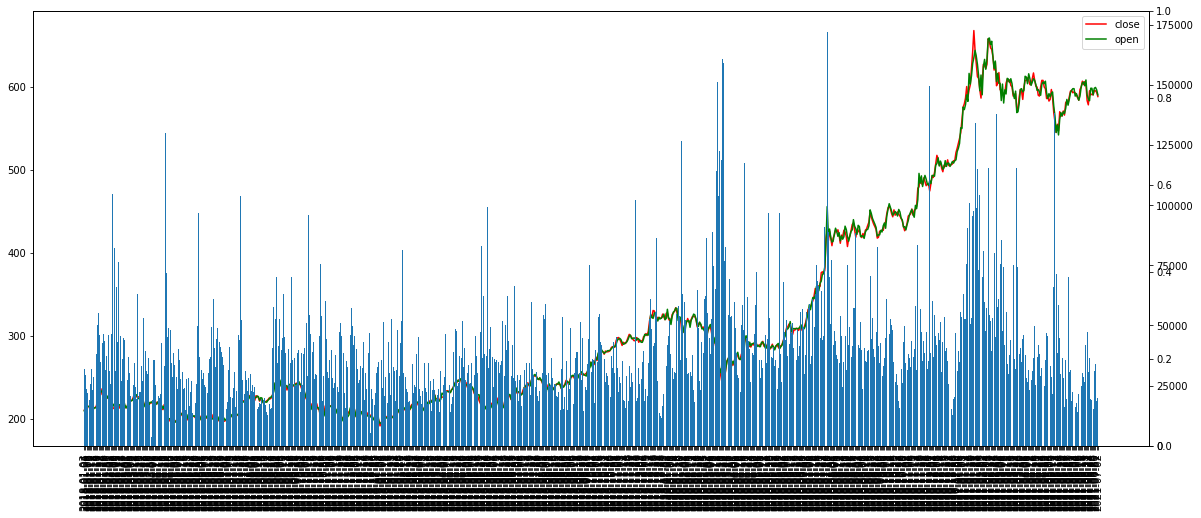

In [4]:
from FinMind.data import DataLoader
dl=DataLoader()
data = dl.taiwan_stock_daily_adj("2330", "2018-01-01", "2021-07-02")

fig=plt.figure(figsize=(20,8))
plt.xticks(rotation = 90)  
ax1 = plt.subplot(111)
ax1.plot(data.close,color='red',label='close')
ax1.plot(data.open,color='green',label='open')
plt.legend()
# twin 為共享x軸
ax2= ax1.twinx()
plt.bar(data.date,data.Trading_Volume.astype('int')//1000)
ax3 = ax1.twinx()

In [5]:
# train, test split
train_size = int(len(data) * 0.7)
test_size = len(data) - train_size
train, test = data[0:train_size], data[train_size:len(data)]

print('Training size: ', train_size)
print('Test size: ', test_size)

#只要Volume
train_set = train['Trading_Volume']
test_set = test['Trading_Volume']

# MinMaxScale
from sklearn.preprocessing import MinMaxScaler 
sc = MinMaxScaler(feature_range = (0, 1))
train_set = train_set.values.reshape(-1, 1)
training_set_scaled = sc.fit_transform(train_set)

print(training_set_scaled[0:10])

Training size:  595
Test size:  256
[[0.17875819]
 [0.16268724]
 [0.12796658]
 [0.11604247]
 [0.09820895]
 [0.14065657]
 [0.18107517]
 [0.12427743]
 [0.15885105]
 [0.12597162]]


In [6]:
look_back=6
X_train = [] 
y_train = []
for i in range(look_back,len(train_set)):
    X_train.append(training_set_scaled[i-look_back:i-1, 0]) 
    y_train.append(training_set_scaled[i-1, 0])

X_train, y_train = np.array(X_train), np.array(y_train) 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

Epoch 1/100
59/59 [==============================] - 3s 4ms/step - loss: 0.0202
Epoch 2/100
59/59 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 3/100
59/59 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 4/100
59/59 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 5/100
59/59 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 6/100
59/59 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 7/100
59/59 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 8/100
59/59 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 9/100
59/59 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 10/100
59/59 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 11/100
59/59 [==============================] - 0s 2ms/step - loss: 0.0116
Epoch 12/100
59/59 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 13/100
59/59 [=================

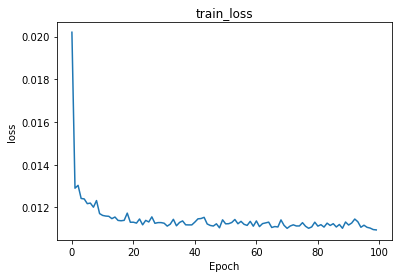

In [7]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

model = Sequential()
model.add(LSTM(units = 100, input_shape = (X_train.shape[1],1)))
model.add(Dense(units = 3))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = model.fit(X_train, y_train, epochs = 100, batch_size = 10)
plt.title('train_loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.plot(history.history["loss"])

In [8]:
dataset_total = pd.concat((train['Trading_Volume'], test['Trading_Volume']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - look_back:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(look_back, len(inputs)):
    X_test.append(inputs[i-look_back:i-1, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_stock_price = model.predict(X_test)
# inverse_transform將股價轉為歸一化前
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


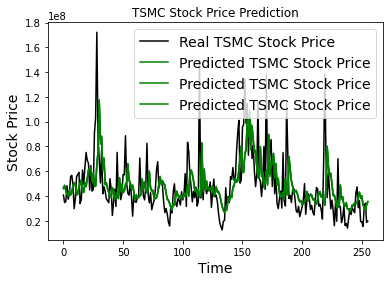

In [19]:
# Plot prediction vs Real
plt.plot(test['Trading_Volume'].values, color = 'black', label = 'Real TSMC Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted TSMC Stock Price')
plt.title('TSMC Stock Price Prediction')
plt.xlabel('Time',size=14)
plt.ylabel('Stock Price',size=14)
plt.legend(fontsize=14)
plt.show()